In [1]:
import glob, os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shutil
%matplotlib notebook
from main import *

In [2]:
#Extracting the SS coverages previously saved and extracted from kMC files
ss_COVG_NONLAT = pd.read_csv('SS_Covg_nonLat.csv')
ss_COVG_LAT = pd.read_csv('SS_Covg_Lat.csv')

In [3]:
#Isolating pressures and ss coverages
Prs_non_lat = ss_COVG_NONLAT.iloc[:,0].to_numpy()
Prs_lat = ss_COVG_LAT.iloc[:,0].to_numpy()
ss_covg_non_lat = ss_COVG_NONLAT.iloc[:,1].to_numpy()
ss_covg_lat = ss_COVG_LAT.iloc[:,1].to_numpy()

In [4]:
#Simulation times from each kMC simulation
t0,tf = 0,750.000000000102

In [5]:
%%time

#Creating NONLAT SSCOVG

#Performing SS MIKI MKM simulations for non lateral case
from main import *
MKM = MKModel('Atomic.csv','Stoich.csv','Param.csv')
MKM.Thermo_Constraint = 'OFF'
MKM.set_limits_of_integration(t0,tf)
MKM.rate_const_correction='None'
MKM_SS_covg_NONLAT = []
Prs = Prs_non_lat
for i in np.arange(len(Prs)):
    MKM.set_rxnconditions(Pr=[Prs[i]])
    MKM_SS_covg_NONLAT = np.append(MKM_SS_covg_NONLAT,MKM.get_SS_coverages(print_warning=False)[0])

Mass is conserved. 

CPU times: user 2.8 s, sys: 12.7 ms, total: 2.81 s
Wall time: 2.88 s


In [6]:
%%time
#Performing SS MIKI MKM simulations for non lateral case
from main import *
MKM = MKModel('Atomic.csv','Stoich.csv','Param.csv')
MKM.Thermo_Constraint = 'OFF'
MKM.set_limits_of_integration(t0,tf)
MKM.rate_const_correction='None'
MKM_SS_covg_LAT = []
Prs = Prs_lat
for i in np.arange(len(Prs)):
    MKM.set_rxnconditions(Pr=[Prs[i]])
    MKM_SS_covg_LAT = np.append(MKM_SS_covg_LAT,MKM.get_SS_coverages(print_warning=False)[0])

Mass is conserved. 

CPU times: user 4.66 s, sys: 10.9 ms, total: 4.67 s
Wall time: 4.67 s


In [7]:
rx = len(ss_covg_lat)
Corr_fac = np.zeros(rx) 

In [8]:
import math
MKM_values = MKM_SS_covg_LAT
KMC_values = ss_covg_lat
def corr_func(MKM_values,KMC_values):
    for i in np.arange(rx):
        num = KMC_values[i]
        den = MKM_values[i]
        #Preventing log(0)
        if float(num) == 0:
            num = 1e-20
        if float(den) == 0:
            den = 1e-20

        frac = num/den
        if float(frac) < 0: #(i.e the rates are either being calculated as consumed versus produced)
            frac = abs(frac)

        val = np.log(frac)
        Corr_fac[i] = val
        if math.isinf(val) or math.isnan(val):
            raise Exception('ERROR: inf or nan is present')
    return Corr_fac

## LSTM learning of corrections

In [9]:
from pandas import read_csv
import math
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)
# fix random seed for reproducibilityz
tf.random.set_seed(7)
# load the dataset
dataframe = pd.DataFrame(corr_func(MKM_values,KMC_values))
dataset = dataframe.values
dataset = dataset.astype('float64')
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# split into train and test sets
# train_size = int(len(dataset) * 0.50)
# test_size = len(dataset) - train_size
# train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
numbers = np.arange(len(dataset))
train_numb = np.array(list(numbers[:5]) + list(numbers)[-8:])
train  = np.array(list(dataset[:5]) + list(dataset)[-8:])

test_numb = np.array(list(numbers[5:-8]))
test = np.array(list(dataset[5:-8]))


# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(128, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=500, batch_size=1, verbose=2)
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

2023-09-05 04:08:42.836352: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/500
11/11 - 1s - loss: 0.1925 - 763ms/epoch - 69ms/step
Epoch 2/500
11/11 - 0s - loss: 0.1469 - 21ms/epoch - 2ms/step
Epoch 3/500
11/11 - 0s - loss: 0.1141 - 15ms/epoch - 1ms/step
Epoch 4/500
11/11 - 0s - loss: 0.0806 - 14ms/epoch - 1ms/step
Epoch 5/500
11/11 - 0s - loss: 0.0607 - 14ms/epoch - 1ms/step
Epoch 6/500
11/11 - 0s - loss: 0.0529 - 11ms/epoch - 1ms/step
Epoch 7/500
11/11 - 0s - loss: 0.0476 - 14ms/epoch - 1ms/step
Epoch 8/500
11/11 - 0s - loss: 0.0457 - 14ms/epoch - 1ms/step
Epoch 9/500
11/11 - 0s - loss: 0.0459 - 12ms/epoch - 1ms/step
Epoch 10/500
11/11 - 0s - loss: 0.0480 - 13ms/epoch - 1ms/step
Epoch 11/500
11/11 - 0s - loss: 0.0460 - 13ms/epoch - 1ms/step
Epoch 12/500
11/11 - 0s - loss: 0.0466 - 10ms/epoch - 945us/step
Epoch 13/500
11/11 - 0s - loss: 0.0463 - 12ms/epoch - 1ms/step
Epoch 14/500
11/11 - 0s - loss: 0.0459 - 14ms/epoch - 1ms/step
Epoch 15/500
11/11 - 0s - loss: 0.0456 - 13ms/epoch - 1ms/step
Epoch 16/500
11/11 - 0s - loss: 0.0461 - 13ms/epoch - 1ms/st

Epoch 130/500
11/11 - 0s - loss: 0.0457 - 11ms/epoch - 976us/step
Epoch 131/500
11/11 - 0s - loss: 0.0445 - 12ms/epoch - 1ms/step
Epoch 132/500
11/11 - 0s - loss: 0.0449 - 11ms/epoch - 1ms/step
Epoch 133/500
11/11 - 0s - loss: 0.0458 - 10ms/epoch - 907us/step
Epoch 134/500
11/11 - 0s - loss: 0.0461 - 12ms/epoch - 1ms/step
Epoch 135/500
11/11 - 0s - loss: 0.0454 - 11ms/epoch - 1ms/step
Epoch 136/500
11/11 - 0s - loss: 0.0447 - 11ms/epoch - 1ms/step
Epoch 137/500
11/11 - 0s - loss: 0.0444 - 10ms/epoch - 941us/step
Epoch 138/500
11/11 - 0s - loss: 0.0444 - 11ms/epoch - 976us/step
Epoch 139/500
11/11 - 0s - loss: 0.0444 - 11ms/epoch - 1ms/step
Epoch 140/500
11/11 - 0s - loss: 0.0447 - 10ms/epoch - 895us/step
Epoch 141/500
11/11 - 0s - loss: 0.0446 - 11ms/epoch - 966us/step
Epoch 142/500
11/11 - 0s - loss: 0.0447 - 11ms/epoch - 986us/step
Epoch 143/500
11/11 - 0s - loss: 0.0441 - 10ms/epoch - 888us/step
Epoch 144/500
11/11 - 0s - loss: 0.0443 - 11ms/epoch - 972us/step
Epoch 145/500
11/11 - 

Epoch 256/500
11/11 - 0s - loss: 0.0403 - 11ms/epoch - 1ms/step
Epoch 257/500
11/11 - 0s - loss: 0.0418 - 11ms/epoch - 973us/step
Epoch 258/500
11/11 - 0s - loss: 0.0405 - 10ms/epoch - 886us/step
Epoch 259/500
11/11 - 0s - loss: 0.0406 - 11ms/epoch - 978us/step
Epoch 260/500
11/11 - 0s - loss: 0.0399 - 10ms/epoch - 918us/step
Epoch 261/500
11/11 - 0s - loss: 0.0420 - 10ms/epoch - 880us/step
Epoch 262/500
11/11 - 0s - loss: 0.0402 - 11ms/epoch - 973us/step
Epoch 263/500
11/11 - 0s - loss: 0.0397 - 10ms/epoch - 930us/step
Epoch 264/500
11/11 - 0s - loss: 0.0400 - 10ms/epoch - 924us/step
Epoch 265/500
11/11 - 0s - loss: 0.0397 - 11ms/epoch - 975us/step
Epoch 266/500
11/11 - 0s - loss: 0.0395 - 10ms/epoch - 942us/step
Epoch 267/500
11/11 - 0s - loss: 0.0398 - 10ms/epoch - 915us/step
Epoch 268/500
11/11 - 0s - loss: 0.0394 - 10ms/epoch - 907us/step
Epoch 269/500
11/11 - 0s - loss: 0.0391 - 11ms/epoch - 958us/step
Epoch 270/500
11/11 - 0s - loss: 0.0400 - 10ms/epoch - 872us/step
Epoch 271/50

Epoch 384/500
11/11 - 0s - loss: 0.0284 - 14ms/epoch - 1ms/step
Epoch 385/500
11/11 - 0s - loss: 0.0292 - 12ms/epoch - 1ms/step
Epoch 386/500
11/11 - 0s - loss: 0.0282 - 14ms/epoch - 1ms/step
Epoch 387/500
11/11 - 0s - loss: 0.0287 - 15ms/epoch - 1ms/step
Epoch 388/500
11/11 - 0s - loss: 0.0282 - 17ms/epoch - 2ms/step
Epoch 389/500
11/11 - 0s - loss: 0.0274 - 15ms/epoch - 1ms/step
Epoch 390/500
11/11 - 0s - loss: 0.0274 - 22ms/epoch - 2ms/step
Epoch 391/500
11/11 - 0s - loss: 0.0274 - 16ms/epoch - 1ms/step
Epoch 392/500
11/11 - 0s - loss: 0.0275 - 16ms/epoch - 1ms/step
Epoch 393/500
11/11 - 0s - loss: 0.0276 - 18ms/epoch - 2ms/step
Epoch 394/500
11/11 - 0s - loss: 0.0271 - 17ms/epoch - 2ms/step
Epoch 395/500
11/11 - 0s - loss: 0.0279 - 17ms/epoch - 2ms/step
Epoch 396/500
11/11 - 0s - loss: 0.0272 - 14ms/epoch - 1ms/step
Epoch 397/500
11/11 - 0s - loss: 0.0274 - 16ms/epoch - 1ms/step
Epoch 398/500
11/11 - 0s - loss: 0.0267 - 15ms/epoch - 1ms/step
Epoch 399/500
11/11 - 0s - loss: 0.0266 

In [10]:
# combined = trainPredictPlot
# for i in np.arange(len(trainPredictPlot)):
#     if i>17:
#         combined[i] = testPredictPlot[i]

In [11]:
Pred_corr_train = trainPredictPlot
Pred_corr_test = testPredictPlot


In [12]:
MKM_SS_covg_LAT_train = []
for i in (train_numb):
    MKM_SS_covg_LAT_train.append(MKM_SS_covg_LAT[i]*np.exp(Pred_corr_train[i]))

In [13]:
MKM_SS_covg_LAT_test = []
for i in (test_numb):
    MKM_SS_covg_LAT_test.append(MKM_SS_covg_LAT[i]*np.exp(Pred_corr_test[i]))

<IPython.core.display.Javascript object>


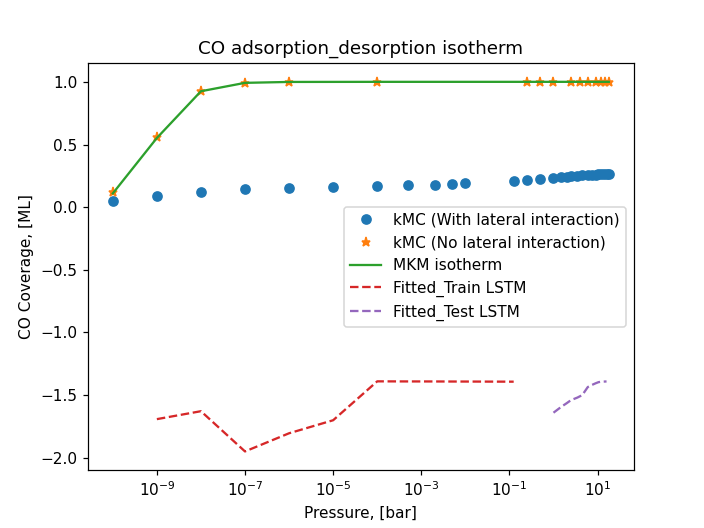

In [14]:
plt.figure()
plt.semilogx(Prs_lat,ss_covg_lat,'o',label='kMC (With lateral interaction)')
plt.semilogx(Prs_non_lat,ss_covg_non_lat,'*',label='kMC (No lateral interaction)')
plt.semilogx(Prs_non_lat,MKM_SS_covg_NONLAT,'-',label='MKM isotherm')
# plt.semilogx(Prs_lat,MKM_SS_covg_LAT,'--',label='MKM_LSTM_Fitted_corr isotherm')
plt.semilogx(Prs_lat,trainPredictPlot,'--',label='Fitted_Train LSTM') #plot
plt.semilogx(Prs_lat,testPredictPlot,'--',label='Fitted_Test LSTM') #plot
plt.legend()
plt.title('CO adsorption_desorption isotherm')
plt.xlabel('Pressure, [bar]')
plt.ylabel('CO Coverage, [ML]')
plt.show()

In [15]:
narray = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

# Extract the first 3 and last 2 values
new_array = narray[:3] + narray[-2:]

print(new_array) #5,4

[1, 2, 3, 9, 10]


In [16]:
print(narray[3:-2])

[4, 5, 6, 7, 8]


In [17]:
test_numb

array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19])

In [18]:
type(dataset)

numpy.ndarray

In [19]:
raw_pres = np.logspace(10e-10, 10e2, num=28, base=10.0)
%%time
#Performing SS MIKI MKM simulations for non lateral case
from main import *
MKM = MKModel('Atomic.csv','Stoich.csv','Param.csv')
MKM.Thermo_Constraint = 'OFF'
MKM.set_limits_of_integration(t0,tf)
MKM.rate_const_correction='None'
new_mkm_MKM_SS_covg_LAT = []
Prs = raw_pres
for i in np.arange(len(Prs)):
    MKM.set_rxnconditions(Pr=[Prs[i]])
    MKM_SS_covg_LAT = np.append(MKM_SS_covg_LAT,MKM.get_SS_coverages(print_warning=False)[0])

/Users/klkusima/opt/anaconda3/lib/python3.9/site-packages/numpy/core/function_base.py:277: RuntimeWarning: overflow encountered in power
  return _nx.power(base, y)
UsageError: Line magic function `%%time` not found.


In [ ]:
corr_func(MKM_values,KMC_values)

In [ ]:
np.arange(5)+1